# **Анализ данных сервиса аренды самокатов и создание рекомендаций по оптимизации затрат и повышению прибыли.**

**У нас есть данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Наша задача - проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти, а именно:**
- ознакомимся с такими данными, как частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолевает за одну поездку, продолжительность поездок и другие,
- рассчитаем доходность различных категорий пользователей (с подпиской и без подписки), 
- оценим соответствие среднего расстояния оптимальному пробегу самоката, при котором не возникает повышенного износа,
- сделаем выводы и рекомендации для бизнеса по оптимизации и повышению доходности.


In [1]:
import pandas as pd

In [2]:
import numpy as np
from scipy import stats as st
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

In [3]:
data_users = pd.read_csv('/datasets/users_go.csv', sep=',')

In [4]:
data_rides = pd.read_csv('/datasets/rides_go.csv', sep=',', parse_dates=['date'])

In [5]:
data_subs = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')

In [6]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [7]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


**В данных о пользователях видим отсутствие пропусков в данных, а также корректные типы данных в столбцах.**

In [8]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**В данных о поездках видим отсутствие пропусков в данных.**

In [10]:
data_subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [11]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**В данных о подписках видим отсутствие пропусков в данных, таблица небольшая, все данные видим в полном объёме, данные и типы данных корректны.**

#### Шаг 2. Предобработка данных

**Проверим, за какой период у нас собраны данные.**

In [12]:
display('Минимальная дата в данных:',data_rides['date'].min())
display('Максимальная дата в данных:',data_rides['date'].max())

'Минимальная дата в данных:'

Timestamp('2021-01-01 00:00:00')

'Максимальная дата в данных:'

Timestamp('2021-12-30 00:00:00')

**Данные у нас собраны за 1 год.**

**Cоздадим новый столбец с номером месяца на основе столбца date.**

In [13]:
data_rides['month']=pd.DatetimeIndex(data_rides['date']).month

In [14]:
data_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Пропусков в данных нет, произведём поиск дубликатов и удалим их при наличии. По данным о пользователях сначала осуществим поиск полных дубликатов, удалим их, в случае их наличия, а затем для контроля проверим наличие дубликатов только по столбцу `user_id`, так как это список пользователей и данные с этом столбце должны быть уникальными, а по данным о поездках будем искать полные дубликаты. Данные о подписках не требуют поиска дубликатов, так как данные все на виду, видно отсутствие дубликатов.**

In [15]:
data_users.duplicated().sum()

31

In [16]:
data_rides.duplicated().sum()

0

In [17]:
data_users = data_users.drop_duplicates().reset_index(drop=True)

In [18]:
data_users['user_id'].duplicated().sum()

0

In [19]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


#### Шаг 3. Исследовательский анализ данных

**Визуализируем общую информацию о пользователях и поездках:**
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

In [20]:
def plots (k, n, m, p):
    k
    plt.title(n, fontsize=24)
    plt.xlabel(m, fontsize=20)
    plt.ylabel(p, fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

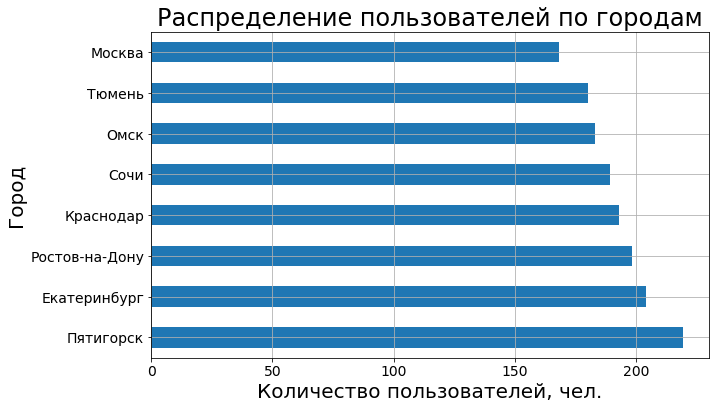

In [21]:
plots(data_users['city'].value_counts().plot(kind='barh', figsize=(10, 6)), \
      'Распределение пользователей по городам', 'Количество пользователей, чел.', 'Город')

**В данных представлены пользователи из 8 городов. Разброс по количеству не очень большой, примерно от 170 до 220 пользователей на город. Наибольшее количество в Пятигорске, наименьшее в Москве. Разница между максимальным и минимальным около 29%.**

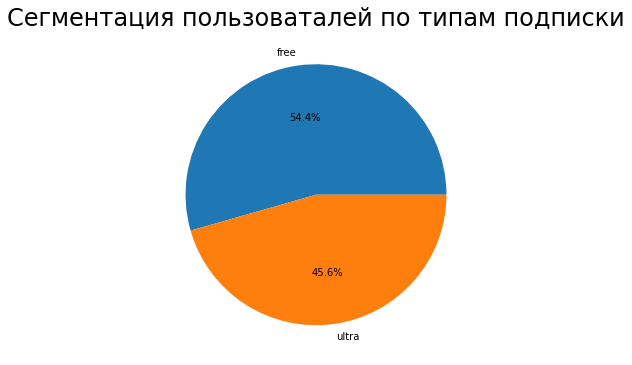

In [22]:
plots(data_users['subscription_type'].value_counts().plot(kind='pie', figsize=(10,6), autopct='%1.1f%%'), \
      'Сегментация пользоваталей по типам подписки', None, None)

**Видим преобладание пользователей без подписки, однако без значительного перевеса, 54.4% против 45,6%.**

In [23]:
def hists (k, n, m, p):
    plt.figure(figsize=(10, 6)) 
    plt.hist(k, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title(n, fontsize=24)
    plt.xlabel(m, fontsize=20)
    plt.ylabel(p, fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

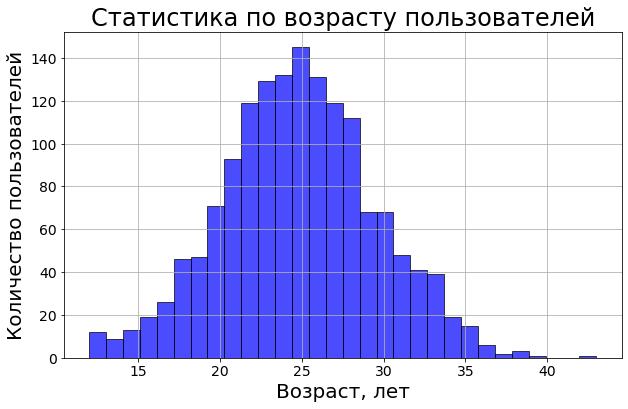

In [24]:
hists(data_users['age'], 'Статистика по возрасту пользователей', 'Возраст, лет', 'Количество пользователей')

**Распределение пользователей по возрастам имеет вид нормального распределения с наибольшим количеством пользователей в возрасте около 25 лет. Минимальный возраст - около 12 лет, а максимальный более 40 лет.**

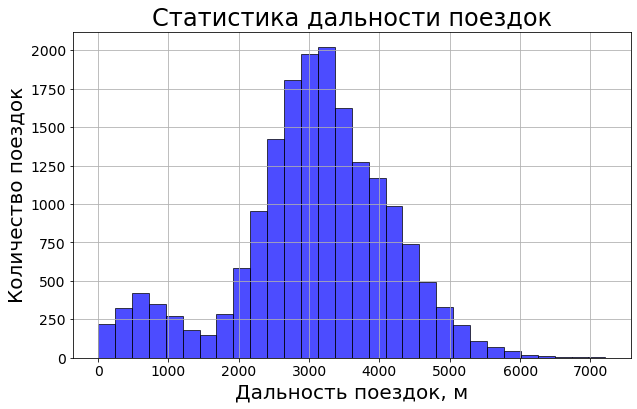

In [25]:
hists(data_rides['distance'], 'Статистика дальности поездок', 'Дальность поездок, м', 'Количество поездок')

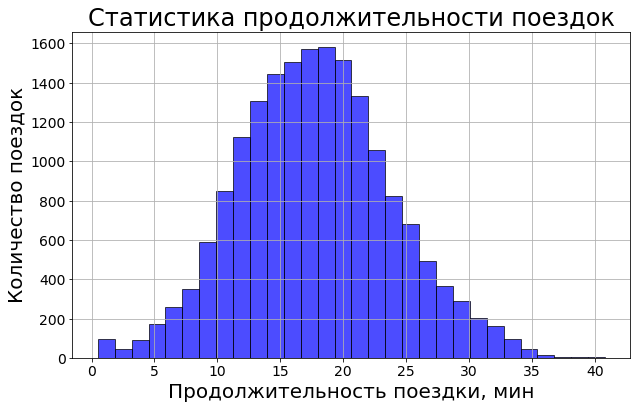

In [26]:
hists(data_rides['duration'], 'Статистика продолжительности поездок', 'Продолжительность поездки, мин', 'Количество поездок')

**По дальности поездки видим гистограмму, имеющую вид нормального распределения с пиком около 3200 метров. Однако имеется небольшой второй пик около 700 метров. Есть предположение о причинах разделения пользователей на две части (совершают короткие и длинные поездки, с пиками около 700-а и 3200-а метров) - наличие конкурента с большим количеством типов подписок, при котором в определенном промежутке (например, на расстояниях порядка 1500 метров) стоимость поездки оказывается дешевле, и определенная категория пользователей выпадает в пользу конкурента.**
**По длительности поездки гистограмма также имеет вид нормального распределения с пиком около 18 минут.**

In [27]:
def boxplots (k, n, p):
    plt.figure(figsize=(10, 6)) 
    plt.boxplot(k)
    plt.title(n, fontsize=24)
    plt.xlabel(None, fontsize=20)
    plt.ylabel(p, fontsize=20)
    plt.xticks([1], [None], fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

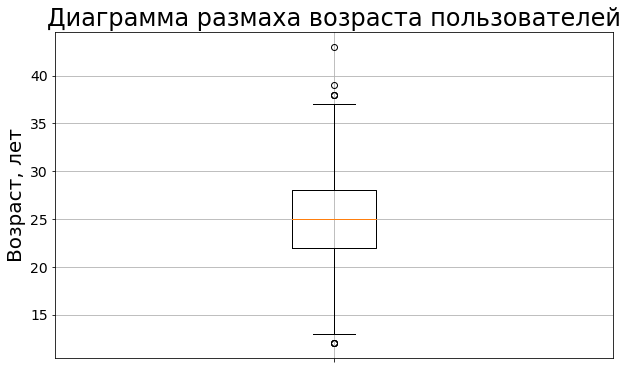

In [28]:
boxplots(data_users['age'], 'Диаграмма размаха возраста пользователей', 'Возраст, лет')

In [29]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Межквартильный размах - от 22 до 28 лет, стандартное отклонение 4,5 года. Межквартильный размах довольно узкий, что говорит о довольно узкой целевой аудитории. Пользователей младше 13 лет и старше 37 лет можно считать случайными или ошибочными данными (выбросы).** 

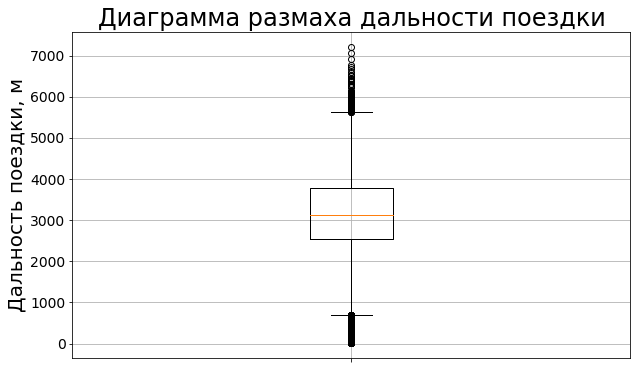

In [30]:
boxplots(data_rides['distance'], 'Диаграмма размаха дальности поездки', 'Дальность поездки, м')

In [31]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

**Межквартильный размах - от 2543 м до 3776 м, стандартное отклонение 1116 м. Межквартильный размах довольно узкий, половина поездок совершается в пределах 2,5-3,7 км. Поездки короче 700 м и длиннее 5,6 км можно считать выбросами.** 

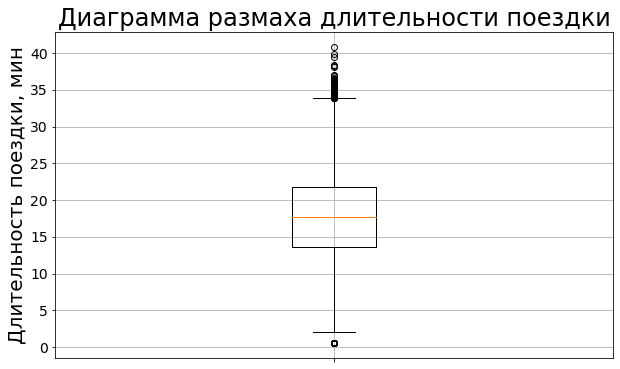

In [32]:
boxplots(data_rides['duration'], 'Диаграмма размаха длительности поездки', 'Длительность поездки, мин')

In [33]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

**Межквартильный размах - от 13 до 21 минут, стандартное отклонение 6 минут. Межквартильный размах довольно узкий, половина поездок совершается в пределах 13-21 минут. Поездки короче 2 минут и дольше 34 минут можно считать выбросами.** 



**Итак, в ходе исследовательского анализа данных были получены следующие данные:**
- В данных представлены пользователи из 8 городов. Разброс по количеству не очень большой, примерно от 170 до 220 пользователей на город. Наибольшее количество в Пятигорске, наименьшее в Москве. Разница между максимальным и минимальным около 29%.
- Видим преобладание пользователей без подписки, однако без значительного перевеса, 54.4% против 45,6%.
- Распределение пользователей по возрастам имеет вид нормального распределения с наибольшим количеством пользователей в возрасте около 25 лет. Минимальный возраст - около 12 лет, а максимальный более 40 лет, однако половина пользователей имеет возраст от 22 до 28 лет, что говорит о довольно узкой целевой аудитории. Пользователей младше 13 лет и старше 37 лет можно считать случайными или ошибочными данными (выбросы).
- По дальности поездки видим гистограмму, имеющую вид нормального распределения с пиком около 3200 метров. Однако имеется небольшой второй пик около 700 метров. Есть предположение о причинах разделения пользователей на две части (совершают короткие и длинные поездки, с пиками около 700-а и 3200-а метров) - наличие конкурента с большим количеством типов подписок, при котором в определенном промежутке (например, на расстояниях порядка 1500 метров) стоимость поездки оказывается дешевле, и определенная категория пользователей выпадает в пользу конкурента. По длительности поездки гистограмма также имеет вид нормального распределения с пиком около 18 минут. Поездки короче 700 м и длиннее 5,6 км, а также короче 2 минут и дольше 34 минут можно считать выбросами.

**Данные с редкими значениями удалим на следующем этапе, после того, как объединим данные из таблиц.**

#### Шаг 4. Объединение данных

**Объединим данные о пользователях, поездках и подписках в один датафрейм. За основу берём таблицу с данными о поездках. Проверим размерность таблиц до и после объединения.**

In [34]:
len(data_rides)

18068

In [35]:
data = (data_rides
        .merge(data_users, on='user_id', how='left')
        .merge(data_subs, on='subscription_type', how='left')
)

In [36]:
if len(data)==len(data_rides):
    display(f'Размерность таблиц до и после объединения одинаковая и равна {len(data)} строк.');
else:
    display(f'Размерность таблицы изменилась. Была {len(data_rides)}, стала {len(data)} строк.')

'Размерность таблиц до и после объединения одинаковая и равна 18068 строк.'

In [37]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


**После объединения таблиц размерность не изменилась, осталось так же 18068 строк. Пропусков в данных нет.**
**Объединение таблиц позволяет лучше проводить аналитику данных, так как позволяет видеть все взаимосвязи между различными данными. До объединения данные были разрознены.**

**Отфильтруем данные, которые ранее мы приняли за редкие значения и выбросы.**

In [39]:
data_filtered=data.drop(data[(data['age']<13)|(data['age']>37)|\
                             (data['distance']<700)|(data['distance']>5600)|\
                             (data['duration']<2)|(data['duration']>34)].index)

In [40]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16757 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            16757 non-null  int64         
 1   distance           16757 non-null  float64       
 2   duration           16757 non-null  float64       
 3   date               16757 non-null  datetime64[ns]
 4   month              16757 non-null  int64         
 5   name               16757 non-null  object        
 6   age                16757 non-null  int64         
 7   city               16757 non-null  object        
 8   subscription_type  16757 non-null  object        
 9   minute_price       16757 non-null  int64         
 10  start_ride_price   16757 non-null  int64         
 11  subscription_fee   16757 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.7+ MB


In [41]:
display(f'Потеря данных после фильтрации редких значений: {round((((len(data)-len(data_filtered))/len(data))*100), ndigits=1)}%')

'Потеря данных после фильтрации редких значений: 7.3%'

**Потеря данных составила 7,3%, это для нас приемлемо, осталось много данных для анализа, но более ценных.**

**Создадим ещё два датафрейма из датафрейма, созданного на предыдущем этапе:**
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [42]:
data_free = data_filtered.query("subscription_type == 'free'")

In [43]:
data_ultra = data_filtered.query("subscription_type == 'ultra'")

In [44]:
if len(data_filtered)==len(data_free)+len(data_ultra):
    display('Размер новых таблиц суммарно равен исходной до разделения')

'Размер новых таблиц суммарно равен исходной до разделения'

In [45]:
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10440 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            10440 non-null  int64         
 1   distance           10440 non-null  float64       
 2   duration           10440 non-null  float64       
 3   date               10440 non-null  datetime64[ns]
 4   month              10440 non-null  int64         
 5   name               10440 non-null  object        
 6   age                10440 non-null  int64         
 7   city               10440 non-null  object        
 8   subscription_type  10440 non-null  object        
 9   minute_price       10440 non-null  int64         
 10  start_ride_price   10440 non-null  int64         
 11  subscription_fee   10440 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.0+ MB


In [46]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6317 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6317 non-null   int64         
 1   distance           6317 non-null   float64       
 2   duration           6317 non-null   float64       
 3   date               6317 non-null   datetime64[ns]
 4   month              6317 non-null   int64         
 5   name               6317 non-null   object        
 6   age                6317 non-null   int64         
 7   city               6317 non-null   object        
 8   subscription_type  6317 non-null   object        
 9   minute_price       6317 non-null   int64         
 10  start_ride_price   6317 non-null   int64         
 11  subscription_fee   6317 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 641.6+ KB


**Размер новых таблиц суммарно равен исходной до разделения. Пропусков в данных новых таблиц нет.**

**Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.**

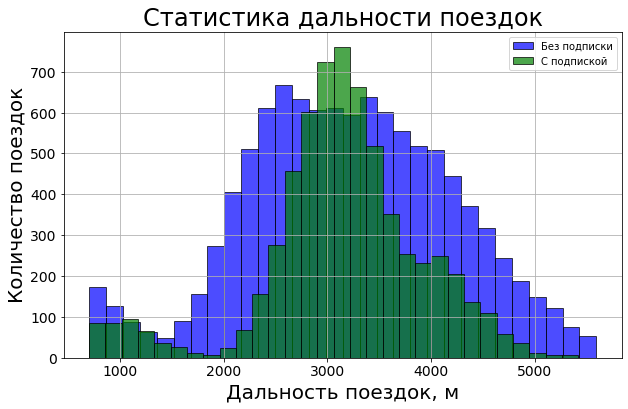

In [47]:
plt.figure(figsize=(10, 6)) 
plt.hist(data_free['distance'], bins=30, color='blue', label='Без подписки', alpha=0.7, edgecolor='black')
plt.hist(data_ultra['distance'], bins=30, color='green', label='С подпиской', alpha=0.7, edgecolor='black')
plt.title('Статистика дальности поездок', fontsize=24)
plt.xlabel('Дальность поездок, м', fontsize=20)
plt.ylabel('Количество поездок', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend()
plt.show()

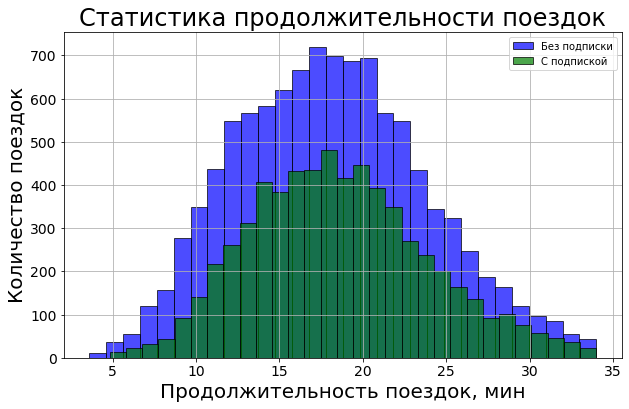

In [48]:
plt.figure(figsize=(10, 6)) 
plt.hist(data_free['duration'], bins=30, color='blue', label='Без подписки', alpha=0.7, edgecolor='black')
plt.hist(data_ultra['duration'], bins=30, color='green', label='С подпиской', alpha=0.7, edgecolor='black')
plt.title('Статистика продолжительности поездок', fontsize=24)
plt.xlabel('Продолжительность поездок, мин', fontsize=20)
plt.ylabel('Количество поездок', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend()
plt.show()

In [49]:
data_free['distance'].describe()

count    10440.000000
mean      3201.801705
std        991.799323
min        701.138423
25%       2511.095033
50%       3191.532926
75%       3916.807971
max       5594.753114
Name: distance, dtype: float64

In [50]:
data_ultra['distance'].describe()

count    6317.000000
mean     3143.657764
std       779.779255
min       701.916838
25%      2801.795195
50%      3152.581137
75%      3558.886226
max      5419.684636
Name: distance, dtype: float64

In [51]:
data_free['duration'].describe()

count    10440.000000
mean        18.078275
std          5.707250
min          3.590815
25%         13.822743
50%         17.874802
75%         21.905746
max         33.987400
Name: duration, dtype: float64

In [52]:
data_ultra['duration'].describe()

count    6317.000000
mean       18.552868
std         5.336015
min         4.832212
25%        14.661316
50%        18.222980
75%        21.867654
max        33.987812
Name: duration, dtype: float64

**По гистограммам и по сравнению статистик методом .describe() видим схожую картину у пользователей с подпиской и без подписки.
По дальности поездки в обоих случаях видим гистограммы, имеющие вид нормального распределения. У гистограммы по данным пользователей без подписки пик приходится на дальность около 2600, а у пользователей с подпиской - около 3100 метров. Однако имеется небольшой второй пик около 700 и 1000 метров соответственно без подписки и с подпиской. По длительности поездки гистограммы также имеют вид нормального распределения с пиком около 17-18 минут для обоих категорий пользователей. Среднее значение и стандартное отклонение по обоим параметрам (дальность поездки и длительность) у обоих категорий пользователей схожи, различия минимальны.**

**Итак, мы объединили имеющиеся таблицы в одну, отсекли редкие значения и проанализировали 2 категории пользователей (с подпиской и без подписки). В результате сравнения мы обнаружили, что общая картина по показателям поездок (дальность и длительность) у обоих категорий пользователей очень схожа, различия минимальны.**

#### Шаг 5. Подсчёт выручки

**Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4 (найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц). В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Перед этим округлим продолжительность каждой поездки до целой минуты в большую сторону.**

In [53]:
data_filtered['duration'] = np.ceil(data_filtered['duration']) 

In [54]:
data_agr = (data_filtered.groupby(['user_id', 'month'])
            .agg({'distance': 'sum', 'duration': ['sum', 'count'], 'date':'first', \
                  'name':'first', 'age':'first', 'city':'first', 'subscription_type':'first', \
                  'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'})
)            

In [55]:
data_agr.head()

distance duration             date  name   age    city  \
                       sum      sum count      first first first   first   
user_id month                                                              
1       1      7027.511294     42.0     2 2021-01-01  Кира    22  Тюмень   
        4       754.159807      7.0     1 2021-04-20  Кира    22  Тюмень   
        8      6723.470560     46.0     2 2021-08-11  Кира    22  Тюмень   
        10     5809.911100     32.0     2 2021-10-09  Кира    22  Тюмень   
        11     7003.499363     56.0     3 2021-11-06  Кира    22  Тюмень   

              subscription_type minute_price start_ride_price subscription_fee  
                          first        first            first            first  
user_id month                                                                   
1       1                 ultra            6                0              199  
        4                 ultra            6                0              199  
        8                 ultra            6                0              199  
        10                ultra            6                0              199  
        11                ultra            6                0              199

In [56]:
data_agr.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10836 entries, (1, 1) to (1534, 12)
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   (distance, sum)             10836 non-null  float64       
 1   (duration, sum)             10836 non-null  float64       
 2   (duration, count)           10836 non-null  int64         
 3   (date, first)               10836 non-null  datetime64[ns]
 4   (name, first)               10836 non-null  object        
 5   (age, first)                10836 non-null  int64         
 6   (city, first)               10836 non-null  object        
 7   (subscription_type, first)  10836 non-null  object        
 8   (minute_price, first)       10836 non-null  int64         
 9   (start_ride_price, first)   10836 non-null  int64         
 10  (subscription_fee, first)   10836 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), 

**Пропусков в данных нет. Удалим лишние столбцы, в информации которых у нас в данном случае нет необходимости, и переименуем столбцы.**

In [57]:
data_agr.drop(columns=data_agr.columns[3:7], inplace=True)

In [58]:
data_agr.columns=['sum_distance', 'sum_duration', 'count_rides', \
                  'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']

In [59]:
data_agr.head()

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199

**Добавим столбец с помесячной выручкой.**

In [60]:
data_agr['monthly_revenue']=(data_agr['start_ride_price']*data_agr['count_rides']
                             + data_agr['minute_price']*data_agr['sum_duration']
                             + data_agr['subscription_fee']
)

In [61]:
data_agr['monthly_revenue'].sum()

3677255.0

In [62]:
data_agr[data_agr['subscription_type']=='free']['monthly_revenue'].sum()

2073512.0

In [63]:
data_agr[data_agr['subscription_type']=='ultra']['monthly_revenue'].sum()

1603743.0

In [64]:
data_agr[data_agr['subscription_type']=='free']['monthly_revenue'].mean()

323.73333333333335

In [65]:
data_agr[data_agr['subscription_type']=='ultra']['monthly_revenue'].mean()

361.9370345294516

In [66]:
data_agr.head()

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  \
user_id month                                                     
1       1                 6                 0               199   
        4                 6                 0               199   
        8                 6                 0               199   
        10                6                 0               199   
        11                6                 0               199   

               monthly_revenue  
user_id month                   
1       1                451.0  
        4                241.0  
        8                475.0  
        10               391.0  
        11               535.0

**Была рассчитана помесячная выручка по каждому пользователю, данные занесены в агрегированную таблицу. По расчетам видим, что среднее значение помесячной выручки пользователя с подпиской выше, чем пользователя без подписки, однако суммарно за счёт большего количества пользователей без подписки выручка от них больше, чем от подписчиков.**

#### Шаг 6. Проверка гипотез

##### **Выясним, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**

**За нулевую гипотезу возьмём предположение, что пользователи с подпиской и пользователи без подписки тратят в среднем одинаковое количество времени на поездки, а за альтернативную - что пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки**

In [67]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

sample_ultra=data_ultra['duration'].sample(n=5000, random_state=1)
sample_free=data_free['duration'].sample(n=5000, random_state=1)

results = st.ttest_ind(sample_ultra, sample_free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0174450299406288e-08
Отвергаем нулевую гипотезу


**Нулевая гипотеза нами отвергается, значит есть основания предполагать, что пользователи с подпиской в среднем тратят больше времени на поездки, что выгодно для бизнеса, так как соответственно будет больше прибыли.**

##### **Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.**

**За нулевую гипотезу возьмём предположение, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров, а за альтернативную - подписчики в среднем проезжают расстояние больше оптимального.**

In [68]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

opt_distance = 3130
sample_ultra_dist=data_ultra['distance'].sample(n=5000, random_state=1)

results = st.ttest_1samp(sample_ultra_dist, opt_distance, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.04095260711030003
Отвергаем нулевую гипотезу


**По результатам теста мы отвергаем нулевую гипотезу, значит можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает оптимальное (3130 метров). На это стоит обратить внимание и либо заложить в статью затрат дополнительную амортизацию оборудования, либо рассмотреть закупку самокатов с большим ресурсом под текущие условия эксплуатации.**

In [69]:
# пример
data_ultra['distance'].mean().round(1)

3143.7

In [70]:
# пример

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

opt_distance = 3130
sample_ultra_dist=data_ultra['distance']

results = st.ttest_1samp(sample_ultra_dist, opt_distance, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.08197399816083184
Нет оснований отвергнуть нулевую гипотезу


##### **Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

**За нулевую гипотезу возьмём предположение, что средняя помесячная выручка от пользователей с подпиской и средняя выручка от пользователей без подписки равны, а за альтернативную - средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем от пользователей без подписки.**

In [71]:
sample_mr_ultra=(data_agr
                 .query("subscription_type == 'ultra'")['monthly_revenue']
                 .sample(n=3000, random_state=1)
)
sample_mr_free=(data_agr
                .query("subscription_type == 'free'")['monthly_revenue']
                .sample(n=3000, random_state=1)
)

results = st.ttest_ind(sample_mr_ultra, sample_mr_free, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 6.726318145642485e-27
Отвергаем нулевую гипотезу


**По результатам теста отвергаем нулевую гипотезу, значит средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем от пользователей без подписки.**

**Представим ситуацию, что техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Для начала необходимо будет определить объём имеющихся генеральных совокупностей и принять решение, будем ли мы делать тест по всей совокупности данных или необходимо будет делать выборку. Затем нам понадобится Т-тест для проверки гипотезы о равенстве средних для зависимых (парных) выборок, при котором будут сравниваться выборка данных с количеством обращений до обновления и после обновления. Нужно будет добавить дополнительный параметр "количество обращений в единицу времени" по каждому пользователю.**

**Затем за нулевую гипотезу возьмём равенство среднего количества обращений в единицу времени в выборках до и после обновления, а за альтернативную гипотезу - что среднее количество обращений до обновления больше, чем после обновления. Уровень статистической значимости берём 0.05, используем параметр alternative = 'greater', проводим тест методом `scipy.stats.ttest_rel()`. Порядок выборки будет такой: `выборка до`, `выборка после`, `alternative='greater'`.**
**В результате теста p-значение сравниваем с уровнем статистической значимости, и если он оказыватся меньше, то отвергаем нулевую гипотезу и принимаем альтернативную, что означает, что среднее количество обращений до изменений было больше, чем после, то есть снизилось в результате обновления.**

# **Общий вывод**

**В ходе выполнения проектной работы была проведена предобработка данных, в ходе которой были найдены и удалены дубликаты, а также наведен порядок в типах данных.**

**В ходе исследовательского анализа мы получили общее представление о следующих данных:**
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

**Также мы объединили данные из разных датафреймов в один и изучили информацию о расстоянии и времени поездок для пользователей с подпиской и без подписки. По гистограммам и по сравнению статистик методом .describe() видим схожую картину у пользователей с подпиской и без подписки. Общая картина, основные параметры, среднее значение и стандартное отклонение по дальности поездки и длительности у обоих категорий пользователей схожи, различия минимальны.**

**Далее мной был произведен подсчет помесячной выручки от каждого пользователя и суммарной выручки.**

**Экономические показатели за год следующие:**
- общая годовая прибыль 3,68 млн руб., из них:
    - прибыль от пользователей с подпиской - 1,6 млн. руб.;
    - прибыль от пользователей без подписки - 2,07 млн. руб.
- средняя ежемесячная прибыль от пользователя с подпиской - 362 руб.;
- средняя ежемесячная прибыль от пользователя без подписки - 324 руб.

**Видим, что среднее значение помесячной выручки пользователя с подпиской выше (примерно на 12%), чем пользователя без подписки, однако суммарно за счёт большего количества пользователей без подписки выручка от них больше, чем от подписчиков.**

**Затем был выдвинут ряд гипотез и сделаны выводы:**
- есть основания предполагать, что пользователи с подпиской тратят больше времени на поездки;
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает оптимальное (3130 метров), стоит обратить внимание и либо заложить в статью затрат дополнительную амортизацию оборудования, либо рассмотреть закупку самокатов с большим ресурсом под текущие условия эксплуатации;
- средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем от пользователей без подписки.

**Рекомендации: сделать упор на стимулирование пользователей оформить подписку, так как ежемесячно каждый средний подписчик приносит больше прибыли, чем пользователь без подписки. Проанализировать тарифные планы конкурентов, возможно имеет смысл расширить варианты подписок. Есть предположение, что в определенном сегменте по дальности поездок пользователи могут отдавать предпочтение конкуренту.**